In [1]:
import sys
sys.path.append("./cls")

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np
import torch.optim as optim


from torch.autograd import Variable
from cls.data import ModelNet40
from util import cal_loss
import cls._init_path
from cls.model_mixup import PointNet, DGCNN, Pointnet2_MSG


parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['pointnet', 'dgcnn', 'pointnet2_MSG'],
                    help='Model to use, [pointnet, dgcnn]')
parser.add_argument('--data', type=str, default='MN40', metavar='N',
                    choices=['MN40', 'SONN_EASY', 'SONN_HARD'])
parser.add_argument('--batch_size', type=int, default=8, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--optim', type=str, default="sgd",
                    choices=['sgd', 'adam'],
                    help='Optimizer, [sgd, adam]')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--scheduler', type=str, default='cos', metavar='N',
                    choices=['cos', 'step'],
                    help='Scheduler to use, [cos, step]')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--eval', type=bool,  default=False,
                    help='evaluate the model')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='initial dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')
parser.add_argument('--model_path', type=str, default='', metavar='N',
                    help='Pretrained model path')

parser.add_argument('--aug', type=str, default='default', metavar='N',
                    choices=['default', 'MN40'])
parser.add_argument("--kermix", type=bool, default= True)    
parser.add_argument("--basemix",type=bool, default=False)
# parser.add_argument("--manimix", type=bool, default=False) 
parser.add_argument("--manimix", type=bool, default=True) 


parser.add_argument('--sigma', type=float, default=0.3) 
parser.add_argument('--beta', type=float, default=0.5)  
parser.add_argument('--no_saliency', action='store_true')
parser.add_argument('--smoothing_k', type=int, default=20) 
parser.add_argument('--temperature', type=float, default=2)
parser.add_argument('--temperature2', type=float, default=1)  
parser.add_argument('--sample_ver', type=int, default=3) 
args = parser.parse_args([])


num_class = 40

train_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=8,
                                batch_size=args.batch_size, shuffle=True, drop_last=False)

print(torch.cuda.device_count())
device = torch.device("cuda")

model = DGCNN(args, num_class).to(device)
# model = PointNet(args, num_class).to(device)
model =  nn.DataParallel(model)
model.load_state_dict(torch.load("cls/base_dgcnn/models/model.t7"))
# model.load_state_dict(torch.load("cls/outputs/pointnet_base_MN40/models/model.t7"))
model = model.module
model.train()


opt = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=1e-4)

criterion2 = cal_loss
# for data, label in train_loader:
#     data, label = data.to(device), label.to(device).squeeze()
#     batch_size = data.size()[0]

#     model.eval()
#     data_var = Variable(data.permute(0, 2, 1), requires_grad=True)
#     logits, _ = model(data_var, mixup=False)
#     loss = criterion2(logits, label, smoothing=False)
#     loss.backward()
#     opt.zero_grad()
#     model.train()
#     saliency = torch.sqrt(torch.mean(data_var.grad**2,1))

# #     logits, _, temp = model(data.permute(0,2,1), label, mixup=True, saliency=saliency, get_mix=True)
#     break
   

/home/ssawmya-local/.conda/envs/CoMix/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1


In [2]:
import torch
from torch.utils.data import DataLoader
import pyvista as pv
import numpy as np

from cls.data_ij import ModelNet40
from util import cal_loss
from emd_ import emd_module
EMD = emd_module.emdModule()

modelnet_test = ModelNet40(partition='test', num_points=2048)

device = torch.device("cuda")

def get_pc(class_num, dataset=modelnet_test, idx=None, num_points=1024):
    if idx==None:
        class_idx = np.where(dataset.label[:]==class_num)[0]
        idx = np.random.choice(class_idx)
    pc = dataset.data[idx]
    return pc[:num_points], idx

def get_pc_batch(batch_size=16, dataset=modelnet_test, idx_list=None, num_points=1024):
    A = []
    rand_classes = np.random.permutation(40)[:batch_size]

    A_idx_list = []
    for c in rand_classes:
        a, a_idx = get_pc(c, dataset=dataset, idx=None, num_points=num_points)
        A.append(a)
        A_idx_list.append(a_idx)
    A = np.stack(A)
    return torch.from_numpy(A), torch.from_numpy(rand_classes), A_idx_list

In [3]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
 
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    return idx
def saliency_smoothing(xyz, saliency, k=20, temperature=2):
    B, N, _ = xyz.shape
    idx = knn(xyz.permute(0,2,1), k)
    idx_base = torch.arange(0, B, device=xyz.device).view(-1, 1, 1)*1024
    idx = idx + idx_base
    idx = idx.view(-1)
    saliency = saliency.view(-1)[idx].reshape(B, N, k) #(b, 1024, k)
    saliency = saliency.mean(-1)**temperature #(b, 1024)

    return saliency
def normalize(weight, axis=None):
    if axis is None:
        weight = (weight-np.min(weight)) / (np.max(weight)-np.min(weight))
    else:
        m = np.expand_dims(np.min(weight, axis), axis)
        M = np.expand_dims(np.max(weight, axis), axis)
        weight = (weight-m) / (M-m)
    return weight

## Prepare viz

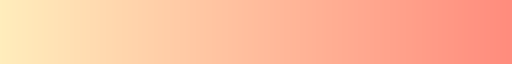

In [4]:
import pyvista as pv
import numpy as np

def get_shadow(plotter, pos, point_size, scale=3, origin=None, opacitiy=0.1, weight=None, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])
    
    if weight is None:
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                            opacity=opacitiy, color = color, lighting=False) 
    else:
        weight = weight.repeat(scale,0)
        point_cloud['y'] = weight
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, cmap = shadow_cmap, lighting=False) 


pv.start_xvfb()
from matplotlib.colors import ListedColormap

s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([252, 211, 3, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
distance_cmap = ListedColormap(color_map.transpose((1,0)))

s_color = np.array([221, 221, 221, 0])/255
e_color = np.array([221, 221, 221, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
shadow_cmap = ListedColormap(color_map.transpose((1,0)))


s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
sal_cmap = ListedColormap(color_map.transpose((1,0)))


s_color = np.array([255, 237, 188, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)

color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap

In [5]:
def visualize_batch(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, index=None):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()
    
    if index==None:
        index = range(len(aug))

    for i in index:
        plotter = pv.Plotter(notebook=True, shape=(1,3))
            
        plotter.subplot(0, 0)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(A[i][:,[0,2,1]])
        # point_cloud['y'] = np.zeros(len(A[i]))
        point_cloud['y'] = A_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, A[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 1)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(aug[i][:,[0,2,1]])
        point_cloud['y'] = aug_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, aug[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 2)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(B[i][:,[0,2,1]])
        # point_cloud['y'] = np.ones(len(B[i]))
        point_cloud['y'] = B_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, B[i][:,[0,2,1]], point_size)

#         light = pv.Light(intensity=0.15, shadow_attenuation = 0)
        light = pv.Light(intensity=0.20, shadow_attenuation = 0)
        light.set_direction_angle(30,0)
        plotter.add_light(light)
#         light = pv.Light(intensity=0.12, shadow_attenuation = 0)
        light = pv.Light(intensity=0.16, shadow_attenuation = 0)
        light.set_direction_angle(30,180)
        plotter.add_light(light)

        plotter.show()
    return plotter
    
def save_pdf(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, filename):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()

    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A[:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = A_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, A[:,[0,2,1]], point_size)

    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug[:,[0,2,1]])
    point_cloud['y'] = aug_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, aug[:,[0,2,1]], point_size)

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B[:,[0,2,1]])
    # point_cloud['y'] = np.ones(len(B[i]))
    point_cloud['y'] = B_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, B[:,[0,2,1]], point_size)

    light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.save_graphic(filename)


In [6]:
camera_pos = [1,-1,1]#,[0,0,1]]
point_size = 9

## Aug Codes

In [4]:
def three_mixup(xyz, label, sigma = args.sigma, theta=0.2, perm=None, idxs=None, alpha=None, beta=args.beta, x=None, saliency=None, n_mix=3):
    # label_ori = label.clone()
    # print(xyz.shape)
    B, N, _ = xyz.shape
    # print("saliency based", saliency_based)
    # mapping = self.find_optimal_mapping(xyz, saliency)
    # return 0
    # print(mapping)
    # return 0
    # print(xyz.shape)
    # idxs = mapping[:,1].to(torch.int64) #torch.randperm(B)
    idxs = torch.stack([torch.randperm(B) for _ in range(n_mix)])
    # idxs = torch.argsort(torch.rand(B, n_clouds))

    xyzs = torch.zeros((n_mix, B, N, 3)).cuda()
    for i in range(n_mix):
        if i == 0: xyzs[i] = xyz
        else:
            xyzs[i] = xyz[idxs[i]]


    all_xyz = torch.zeros((n_mix, B, N, 3)).cuda()
    all_xyz[0] = xyzs[0]

    all_saliency = torch.zeros((n_mix, B, N)).cuda()
    all_saliency[0] = saliency
    for i in range(1, n_mix):
        _, ass = EMD(xyzs[0], xyzs[i], 0.005, 500)
        #cast ass to long tensor
        ass = ass.type(torch.long)

        xyz_new = torch.zeros_like(xyzs[i]).cuda()
        saliency_new = torch.zeros_like(saliency).cuda()
        
        
        # print(ass,ass.shape)
        for j in range(B):
            # print(ass[j].dtype)
            # print("ass j", ass[j])
            # print("ass j shape", ass[j].shape)
            # print("xyzs shape", xyzs.shape)
            # print("xyzs i shape", xyzs[i].shape)
            all_xyz[i][j] = xyzs[i][j][ass[j]]
            all_saliency[i][j] = saliency[idxs[i]][j][ass[j]]

            # xyz_new[i] = xyzs[j][ass[j]]
            # saliency_new[j] = saliency[idxs[j]][j][ass[j]]
        
        # all_xyz[i] = xyz_new
        # all_saliency[i] = saliency_new
        # print("permuted saliency", saliency[1])

        anchors = torch.zeros(n_mix, B, 3).cuda()

        saliency = saliency/saliency.sum(-1, keepdim=True)
        anc_idx = torch.randint(0, 1024, (B,1)).cuda()
        # anc_idx = torch.multinomial(saliency, 1, replacement=True)
        anchor_ori = all_xyz[0][torch.arange(B), anc_idx[:,0]]
        anchors[0] = anchor_ori
        # # print("anchor shape", anchor_ori.shape)

        anc_idx_new = 0
        perm_saliency_new = 0
        perm_saliencies = torch.zeros((n_mix-1, B, N)).cuda()
        # ker_weight_fix = 0
        for i in range(1, n_mix):
            dists = []
            for j in range(0,i):
                # print("all_xyz", all_xyz[i])
                # print("anchors", anchors)
                sub = all_xyz[i] - anchors[j][:, None, :]
                # subs.append(sub)
                dist = ((sub) ** 2).sum(2).sqrt()
                dists.append(dist)
                # print(dist.shape)
            dist = torch.stack(dists).sum(dim=0)
            
            perm_saliency_new = all_saliency[i] * dist
            perm_saliency_new = perm_saliency_new/perm_saliency_new.sum(-1, keepdim=True)
            perm_saliencies[i-1] = perm_saliency_new
            anc_idx_new = torch.randint(0, 1024, (B,1)).cuda()
            anchor_perm_new = all_xyz[i][torch.arange(B),anc_idx_new[:,0]]
            anchors[i] = anchor_perm_new
       
        pi = torch.distributions.dirichlet.Dirichlet(torch.tensor([theta for i in range(n_mix)])).sample((B,)).cuda()

        kerns = torch.zeros(n_mix, B, N).cuda()
        weights = torch.zeros(n_mix, B, N).cuda()
        weights_copy = []
        for i in range(n_mix):
            sub_ori = all_xyz[i] - anchors[i][:,None,:]
            sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
        #     #Eq.(6) for first sample
            ker_weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
            kerns[i] = ker_weight_ori
        #     # print("kern weight ori", ker_weight_ori.shape)

            weights[i] = ker_weight_ori * pi[:,i][:,None]
            weights_copy.append(weights[i][...,None])

            # ker_weight_fix = ker_weight_ori


        # # weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
        weight = (torch.cat(weights_copy,-1)) + 1e-16
        weight = weight/weight.sum(-1)[...,None]
        print("weight shape", weight.shape,"total weights",weights.shape)
        print("perm_saliency_new:",perm_saliency_new.shape)
        print("all_saliency",all_saliency.shape)
        print("saliency",saliency.shape)
        
        weight_old = weight.clone()
        x = torch.zeros((B, N, 3)).cuda()

        for i in range(n_mix):
            x += weight[:, :, i:i+1] * all_xyz[i]
        saliency_new = torch.zeros((B, N)).cuda()
        # saliency_new = 0
        for i in range(n_mix):
            if(i == 0):
                print(weight[:,:,i:i+1].shape)
                saliency_new += weight[:,:,i] * saliency
            else:
                saliency_new += weight[:, :, i] * perm_saliencies[i-1]
        
        print("saliency_new:",saliency_new.shape)

        target = weight.sum(1)
        target = target / target.sum(-1, keepdim=True)

        label_one_hots = torch.zeros(n_mix, B, num_class).cuda()
        label_onehot = torch.zeros(B, num_class).cuda().scatter(1, label.view(-1, 1), 1)
        label_one_hots[0] = label_onehot
        # print("label_onehot shape", label_onehot.shape)

        label = torch.zeros(B, num_class).cuda()
        label += label_one_hots[0] * target[:, 0, None]
        
        for i in range(1, n_mix):
            label_perm_onehot = label_onehot[idxs[i]]
            label += label_perm_onehot * target[:, i, None]
        
        return x, label, {"mix" : x.cpu().numpy(), "perm_idxs" : idxs.cpu().numpy(),"all_perm":xyzs.cpu().numpy(),"anchors":anchors.cpu().numpy(),
        "saliency_new":saliency_new.cpu().numpy(),"perm_saliencies":perm_saliencies.cpu().numpy(),"saliency_ori":saliency.cpu().numpy(),"kerns_weight":kerns.cpu().numpy(),
        "weight":weight.cpu().numpy(),"weight_old":weight_old.cpu().numpy(),"target":target.cpu().numpy(),"label":label.cpu().numpy(),"label_onehot":label_onehot.cpu().numpy()}
            #   "perm" : perm_new, "ker_weight_perm" : ker_weight_perm, "weight_perm":weight_perm,
            #   "ker_weight_ori" : ker_weight_ori,"weight_ori":weight_ori, "alpha":alpha, \
            #   "saliency" : saliency, "saliency_perm_no_dist": saliency_perm_no_dist, "saliency_perm" : saliency_perm, "ratio":weight, "anchor_ori":anchor_ori, "anchor_perm":anchor_perm,
            #   "saliency_new" : saliency_new}

# 2D Case

In [69]:
def mixup(xyz, label, sigma, perm=None, idxs=None, alpha=None, beta=args.beta, x=None, saliency=None):
    """
    Args:
        xyz (B,N,3): 
        label (B): 
        x (B,D,N): Defaults to None.
        saliency (B,N): Defaults to None.
    """        
    
    rtn = dict()
    
    beta = torch.distributions.beta.Beta(torch.tensor([beta]), torch.tensor([beta]))
    B, N, _ = xyz.shape    
    if perm is None:

        idxs = torch.randperm(B)
        while (idxs==torch.arange(B)).sum():
            idxs = torch.randperm(B)
        perm = xyz[idxs]

    _, ass = EMD(xyz, perm, 0.005, 10000) # mapping
    ass = ass.long()
    perm_new = torch.zeros_like(perm).cuda()
    if saliency is not None:
        saliency = saliency_smoothing(xyz, saliency)
        saliency_perm = torch.zeros_like(saliency).cuda()

    for i in range(B):
        perm_new[i] = perm[i][ass[i]]
        if saliency is not None:
            saliency_perm[i] = saliency[idxs][i][ass[i]]

    #random_sampling
    if saliency is None:
        anc_idx = torch.randperm(args.num_points)[:2]
        anchor_ori, anchor_perm = xyz[:,anc_idx[0],:], perm_new[:,anc_idx[1], :]
    #weighted sampling
    else:
        #max_to_max
        if args.sample_ver == 0:
            saliency = saliency/saliency.sum(-1, keepdim=True)
            saliency_perm = saliency_perm/saliency_perm.sum(-1, keepdim=True)
            anc_idx = torch.multinomial(saliency, 1, replacement=True)
            anc_idx2 = torch.multinomial(saliency_perm, 1, replacement=True)
            anchor_ori = xyz[torch.arange(B),anc_idx[:,0]]
            anchor_perm = perm_new[torch.arange(B),anc_idx2[:,0]]

        #max_to_min
        elif args.sample_ver == 1:
            saliency_perm =1/saliency_perm

            saliency = saliency/saliency.sum(-1, keepdim=True)
            saliency_perm = saliency_perm/saliency_perm.sum(-1, keepdim=True)

            anc_idx = torch.multinomial(saliency, 1, replacement=True)
            anc_idx2 = torch.multinomial(saliency_perm, 1, replacement=True)
            anchor_ori = xyz[torch.arange(B),anc_idx[:,0]]
            anchor_perm = perm_new[torch.arange(B),anc_idx2[:,0]]

        #min_to_min
        elif args.sample_ver == 2:
            saliency = 1/saliency
            saliency_perm = 1/saliency_perm

            saliency = saliency/saliency.sum(-1, keepdim=True)
            saliency_perm = saliency_perm/saliency_perm.sum(-1, keepdim=True)

            anc_idx = torch.multinomial(saliency, 1, replacement=True)
            anc_idx2 = torch.multinomial(saliency_perm, 1, replacement=True)
            anchor_ori = xyz[torch.arange(B),anc_idx[:,0]]
            anchor_perm = perm_new[torch.arange(B),anc_idx2[:,0]]

        #max_to_max, distance based re-weighting
        elif args.sample_ver == 3:
            saliency = saliency/saliency.sum(-1, keepdim=True)


            # anc_idx = torch.multinomial(saliency, 1, replacement=True)
            anc_idx = torch.argmax(saliency, 1, keepdim=True)
            anchor_ori = xyz[torch.arange(B),anc_idx[:,0]]

            sub = perm_new - anchor_ori[:,None,:]
            dist = ((sub) ** 2).sum(2).sqrt()
            
            saliency_perm_no_dist = saliency_perm/saliency_perm.sum(-1, keepdim=True)
            saliency_perm = saliency_perm * dist
            saliency_perm = saliency_perm/saliency_perm.sum(-1, keepdim=True)

            anc_idx2 = torch.multinomial(saliency_perm, 1, replacement=True)
            anc_idx2 = torch.argmax(saliency_perm, 1, keepdim=True)
            anchor_perm = perm_new[torch.arange(B),anc_idx2[:,0]]


    if alpha is not None:
        alpha = alpha
    elif beta is not None:
        alpha = beta.sample((B,)).cuda()
    else:
        alpha = 0.5

    sub_ori = xyz - anchor_ori[:,None,:]
    sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
    ker_weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)

    sub_perm = perm_new - anchor_perm[:,None,:]
    sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
    ker_weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma ** 2))  #(M,N)

    weight_ori = ker_weight_ori * alpha 
    weight_perm = ker_weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
    weight = weight/weight.sum(-1)[...,None]

    x = weight[:,:,0:1] * xyz + weight[:,:,1:] * perm_new
    x = x.permute(0,2,1)
    
    saliency = normalize(saliency.cpu().numpy(), 1)
    saliency_perm = normalize(saliency_perm.cpu().numpy(), 1)
    saliency_perm_no_dist = normalize(saliency_perm_no_dist.cpu().numpy(), 1)
    saliency_new = weight[:,:,0].cpu().numpy() * saliency \
                    + weight[:,:,1].cpu().numpy() * saliency_perm_no_dist


    #label generation
    target = weight.sum(1)
    target = target / target.sum(-1, keepdim=True)
    # label_onehot = torch.zeros(B, num_class).cuda().scatter(1, label.view(-1, 1), 1)
    # label_perm_onehot = label_onehot[idxs]
    # label = target[:, 0, None] * label_onehot + target[:, 1, None] * label_perm_onehot 

    return x, label, {"mix" : x, "perm_idxs" : idxs,
              "perm" : perm_new, "ker_weight_perm" : ker_weight_perm, "weight_perm":weight_perm,
              "ker_weight_ori" : ker_weight_ori,"weight_ori":weight_ori, "alpha":alpha, \
              "saliency" : saliency, "saliency_perm_no_dist": saliency_perm_no_dist, "saliency_perm" : saliency_perm, "ratio":weight, "anchor_ori":anchor_ori, "anchor_perm":anchor_perm,
              "saliency_new" : saliency_new}
                


In [73]:
data, label, idx_list = get_pc_batch()
data, label = data.to(device), label.to(device).squeeze()
batch_size = data.size()[0]

model.eval()
data_var = Variable(data.permute(0, 2, 1), requires_grad=True)
logits, _ = model(data_var)
loss = criterion2(logits, label, smoothing=False)
loss.backward()
opt.zero_grad()
model.train()
saliency = torch.sqrt(torch.mean(data_var.grad**2,1))   

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cuda:1! (when checking arugment for argument weight in method wrapper_cudnn_convolution)

# Back again

In [8]:
data = torch.from_numpy(np.load("../Data_for_viz/data_unmixed_3.npy")).to(device)
label = torch.from_numpy(np.load("../Data_for_viz/label_unmixed_3.npy")).to(device)
saliency = torch.from_numpy(np.load("../Data_for_viz/saliency_3.npy")).to(device)

In [81]:
# label = torch.tensor([ 5, 30, 33, 17, 19, 10, 28, 16, 25,  0, 27, 26, 24, 11, 29, 12]).to(device)
# data = A.to(device)
# model.eval()
# data_var = Variable(data.permute(0, 2, 1), requires_grad=True)
# logits, _ = model(data_var, mixup=False)
# loss = criterion2(logits, label, smoothing=False)
# loss.backward()
# opt.zero_grad()
# model.train()
# saliency = torch.sqrt(torch.mean(data_var.grad**2,1)) 

In [9]:
x,label_mix, dic = three_mixup(data, label, sigma=args.sigma, perm=None, idxs=None, alpha=None, beta=args.beta, x=None, saliency=saliency, n_mix=3)

weight shape torch.Size([24, 1024, 3]) total weights torch.Size([3, 24, 1024])
perm_saliency_new: torch.Size([24, 1024])
all_saliency torch.Size([3, 24, 1024])
saliency torch.Size([24, 1024])
torch.Size([24, 1024, 1])
saliency_new: torch.Size([24, 1024])


In [12]:
print(dic.keys())

dict_keys(['mix', 'perm_idxs', 'all_perm', 'anchors', 'saliency_new', 'perm_saliencies', 'saliency_ori', 'kerns_weight', 'weight', 'weight_old', 'target', 'label', 'label_onehot'])


In [13]:
#save dic, x and label_mix in a pickle file
big_dic = {"x":x.cpu().numpy(), "label_mix":label_mix.cpu().numpy(), "dic":dic}
import pickle
with open('three_mixup_batch_3.pkl', 'wb') as f:
    pickle.dump(big_dic, f)


In [11]:
x, label, dic = mixup(data, label, sigma=0.3, saliency=saliency)
path = "./injae/image/origin/03/"
A = data
B = dic['perm']
aug = dic['mix'].permute(0,2,1)
aug_weight = normalize(1-dic['ker_weight_ori'].cpu().numpy(), 1)
aug_weight = dic['ratio'][:,:,1].cpu().numpy()
A_saliency = dic['saliency']
B_saliency = dic['saliency_perm_no_dist']
saliency_new = dic['saliency_new']

NameError: name 'mixup' is not defined

In [83]:
# torch.save(A, "./injae/A.pt")
# torch.save(B, "./injae/B.pt")
# torch.save(aug, "./injae/aug.pt")
# A = torch.load("./injae/A.pt")
# B = torch.load("./injae/B.pt")
# aug = torch.load("./injae/aug.pt")

In [84]:
# x, label, dic = mixup(data, label, perm=B, idxs=dic['perm_idxs'], sigma=0.3, saliency=saliency)
# # x, label, dic = mixup(data, label, perm=B, idxs=dic['perm_idxs'], alpha=0.03, sigma=0.3, saliency=saliency)
# path = "./injae/image/origin/03/"
# A = data
# B = dic['perm']
# aug = dic['mix'].permute(0,2,1)
# aug_weight = normalize(1-dic['ker_weight_ori'].cpu().numpy(), 1)
# aug_weight = dic['ratio'][:,:,1].cpu().numpy()
# A_saliency = dic['saliency']
# B_saliency = dic['saliency_perm_no_dist']
# saliency_new = dic['saliency_new']

0


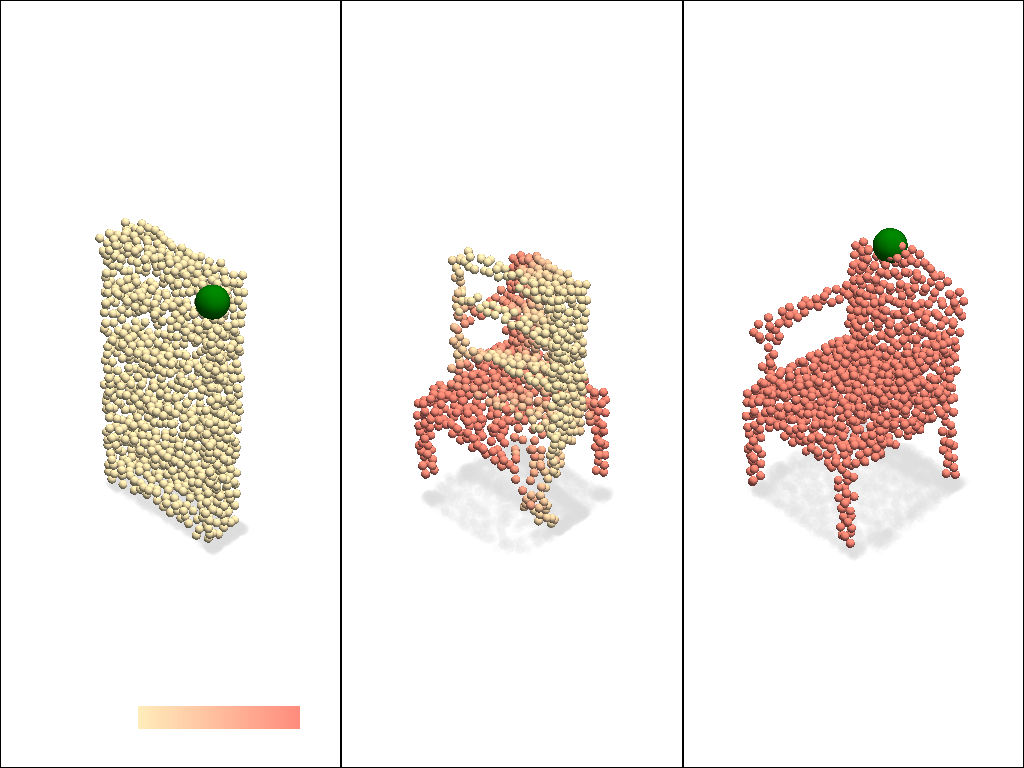

1


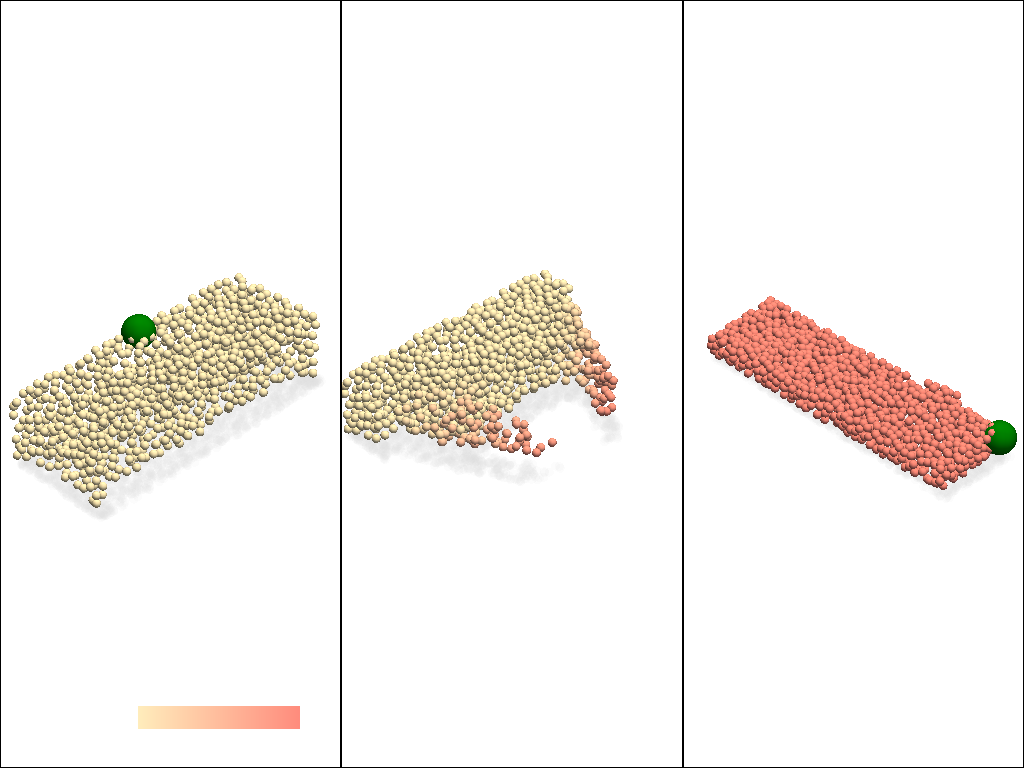

4


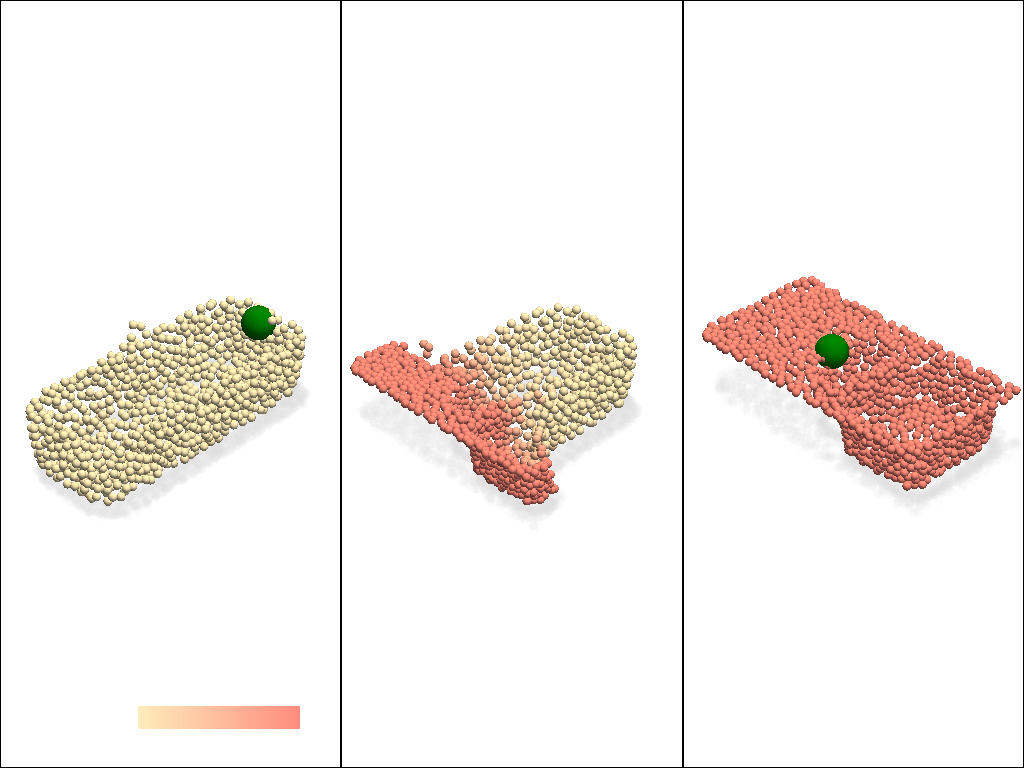

5


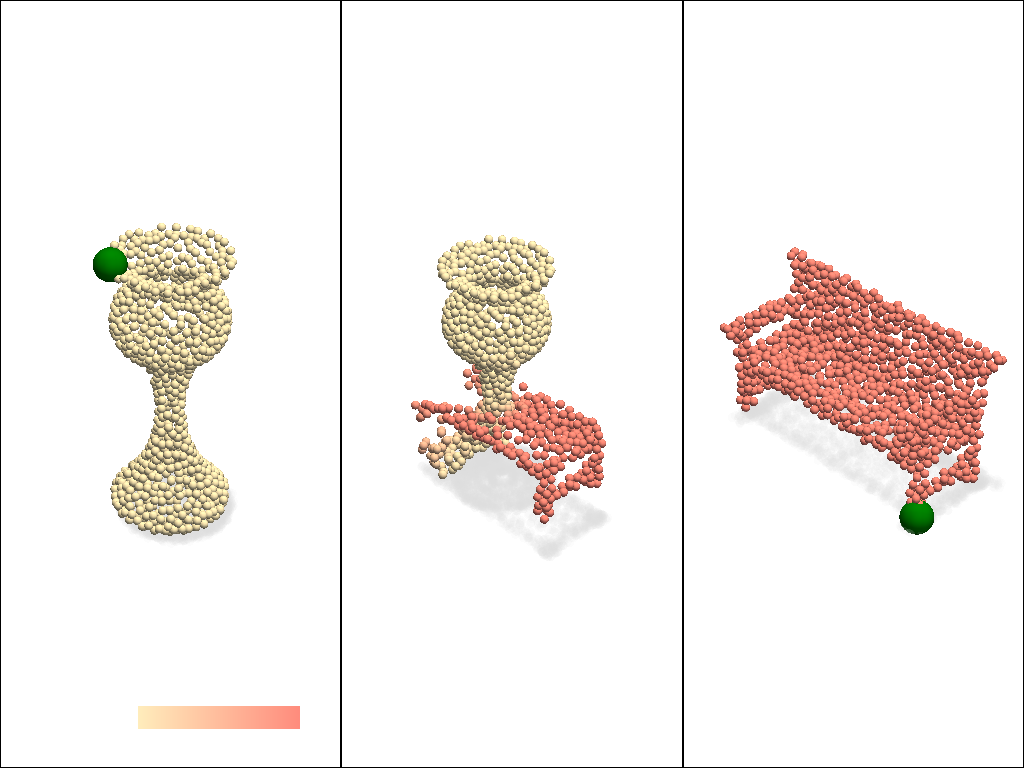

6


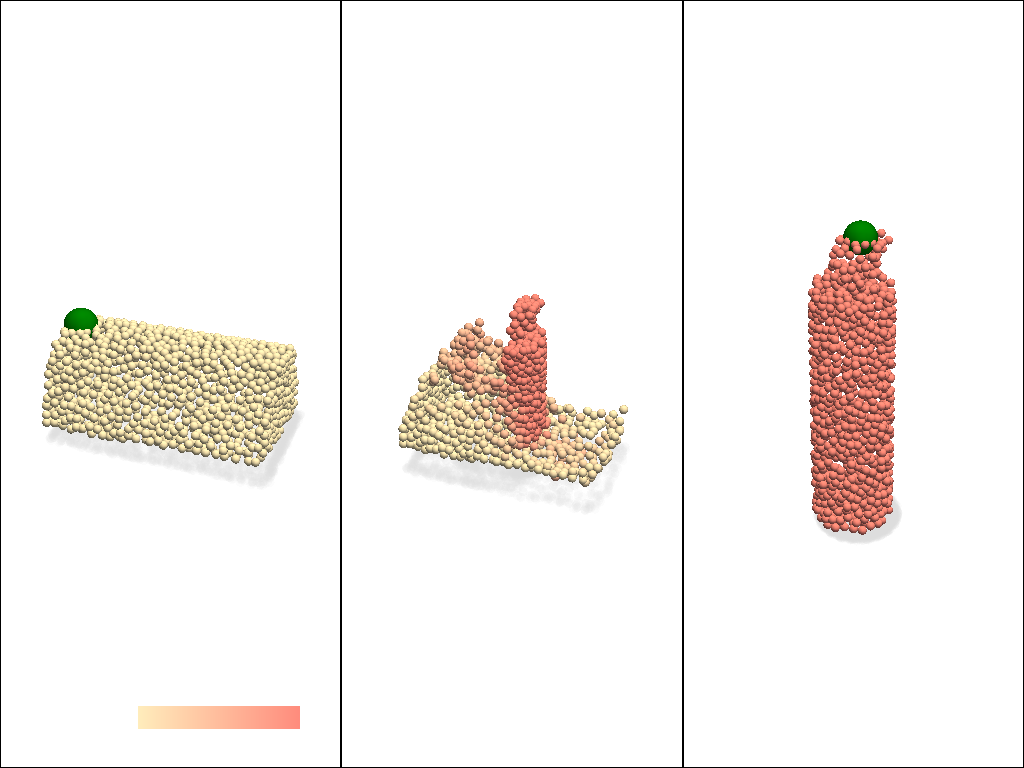

7


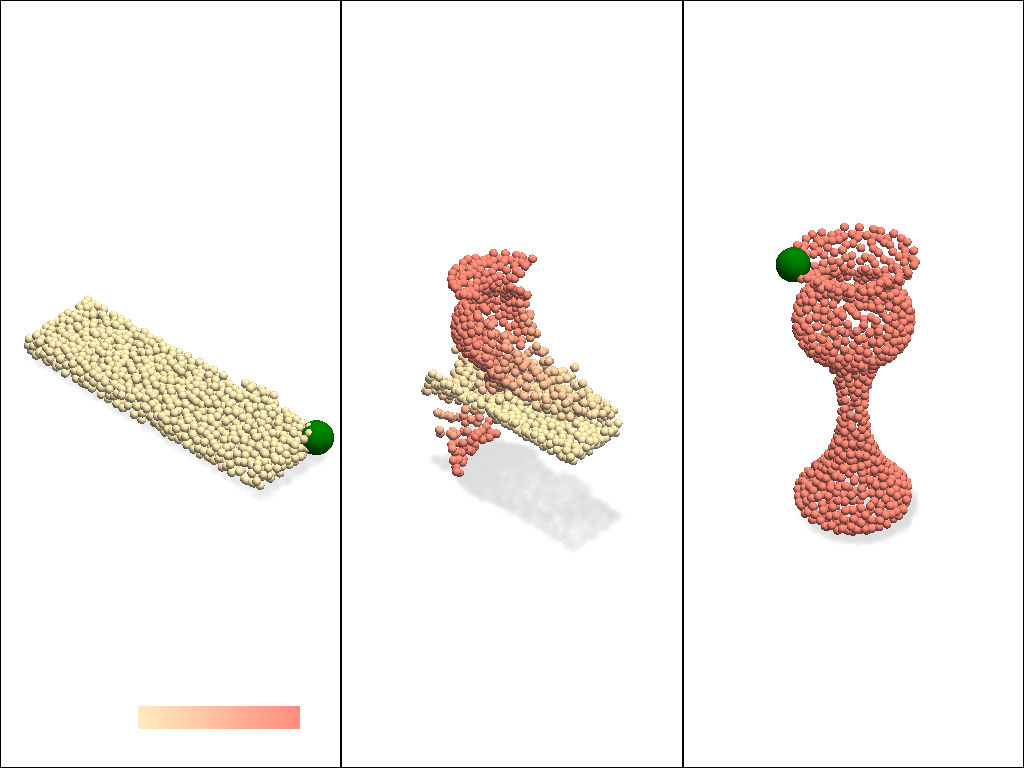

8


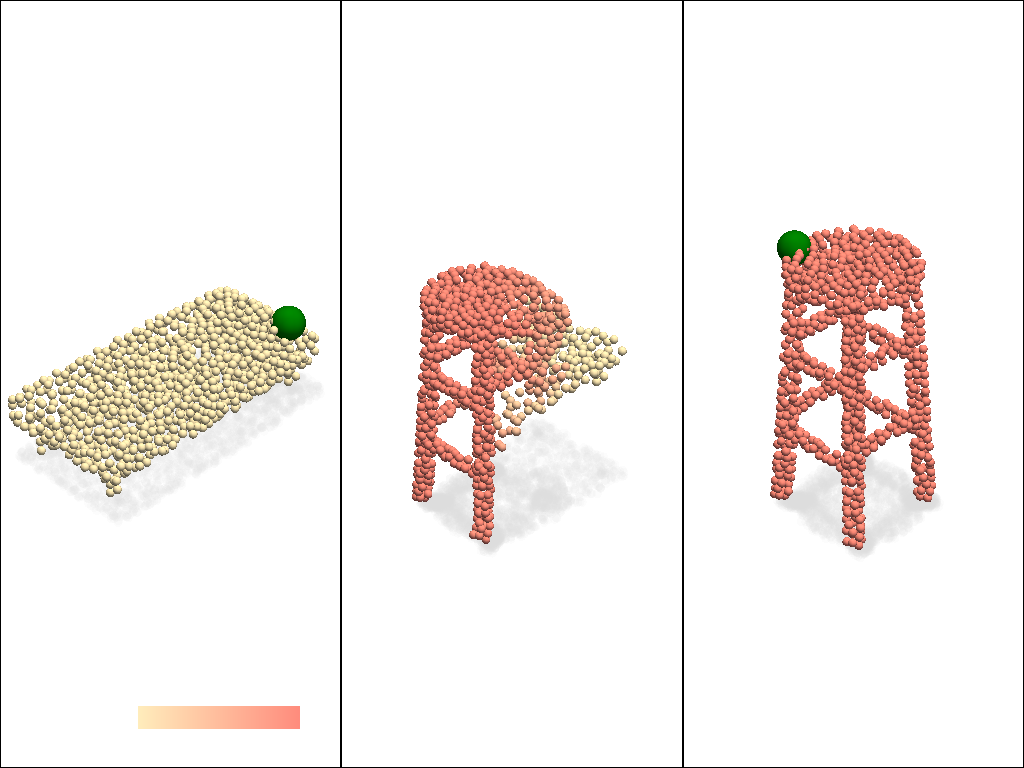

9


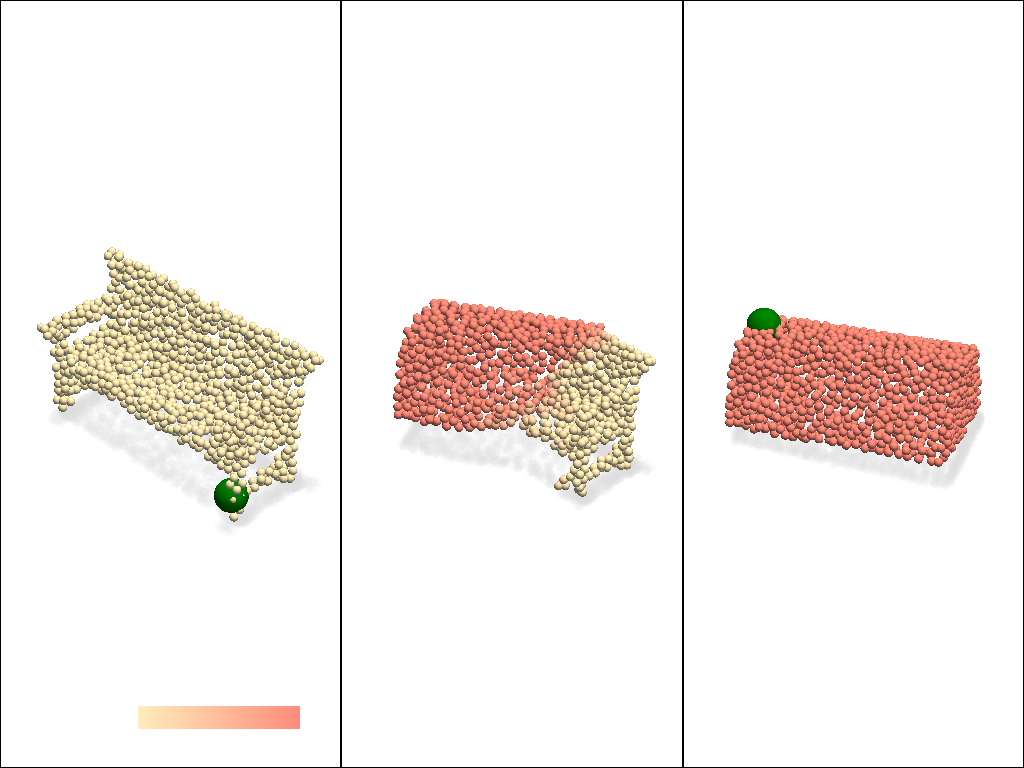

10


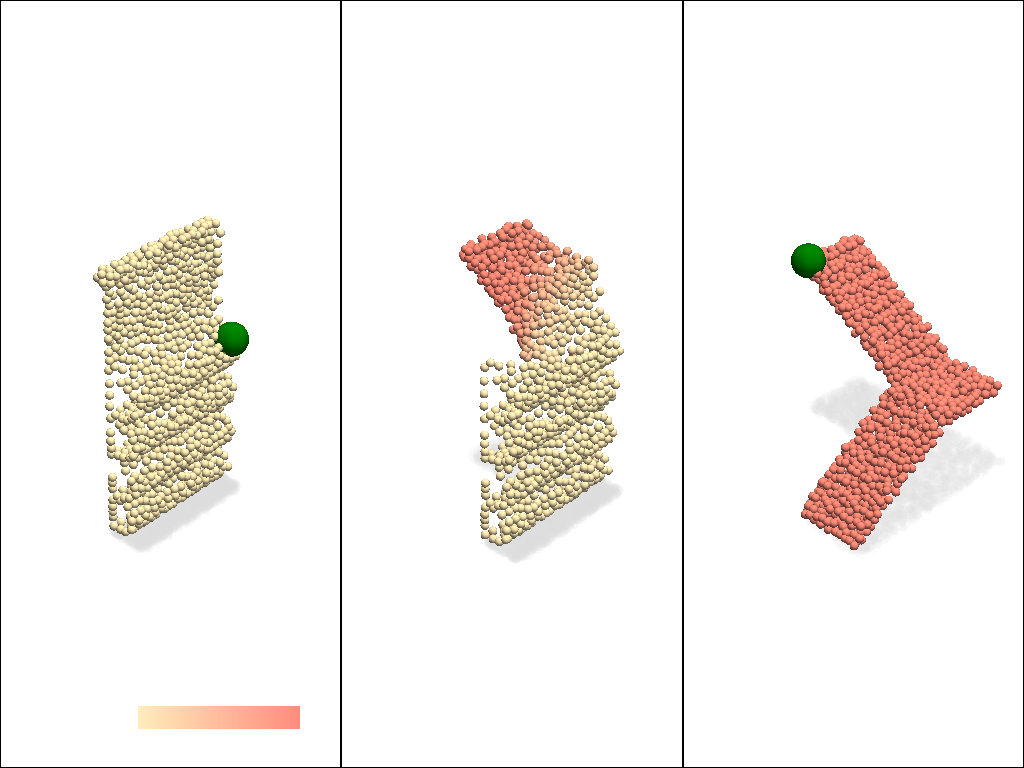

11


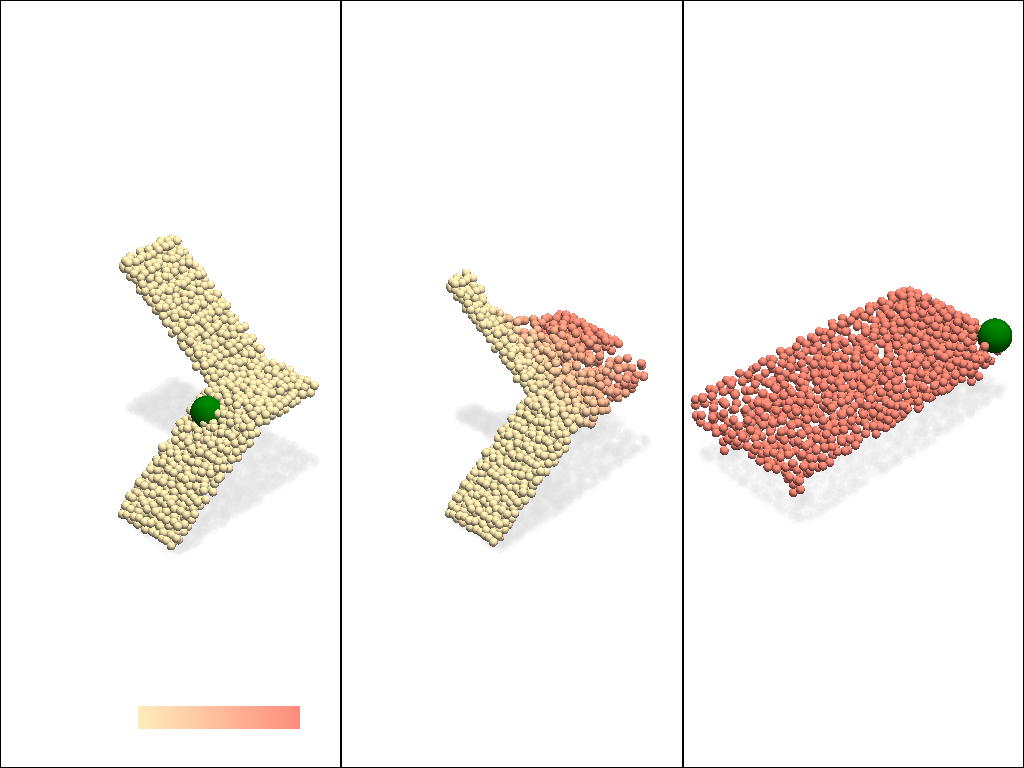

12


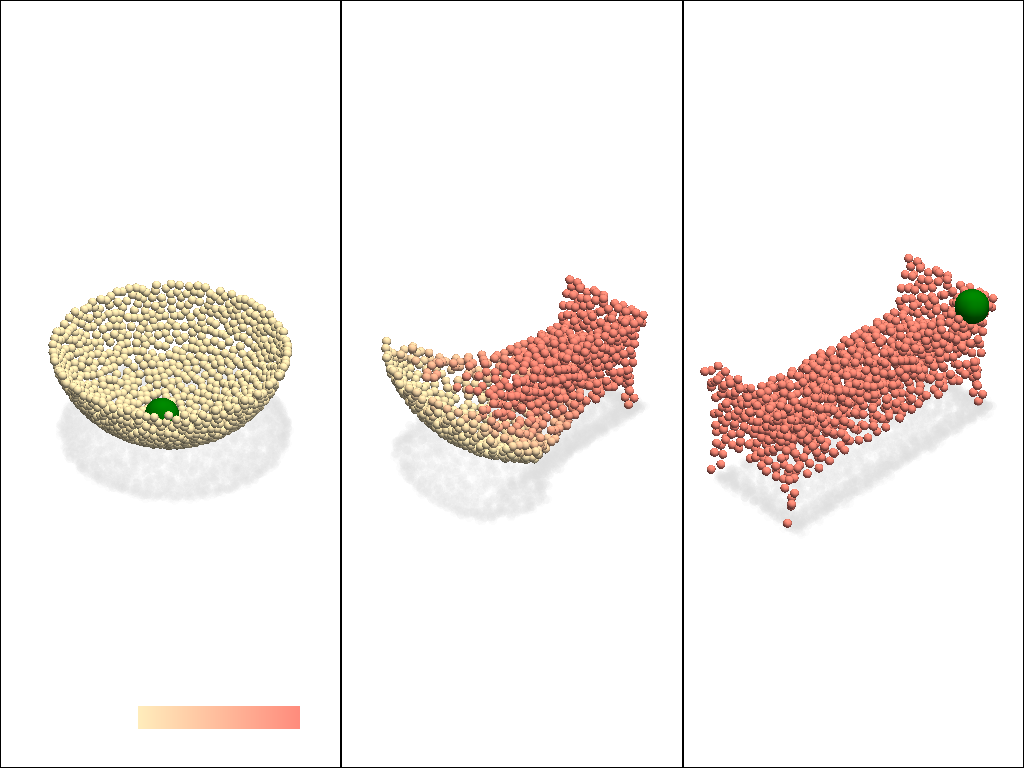

13


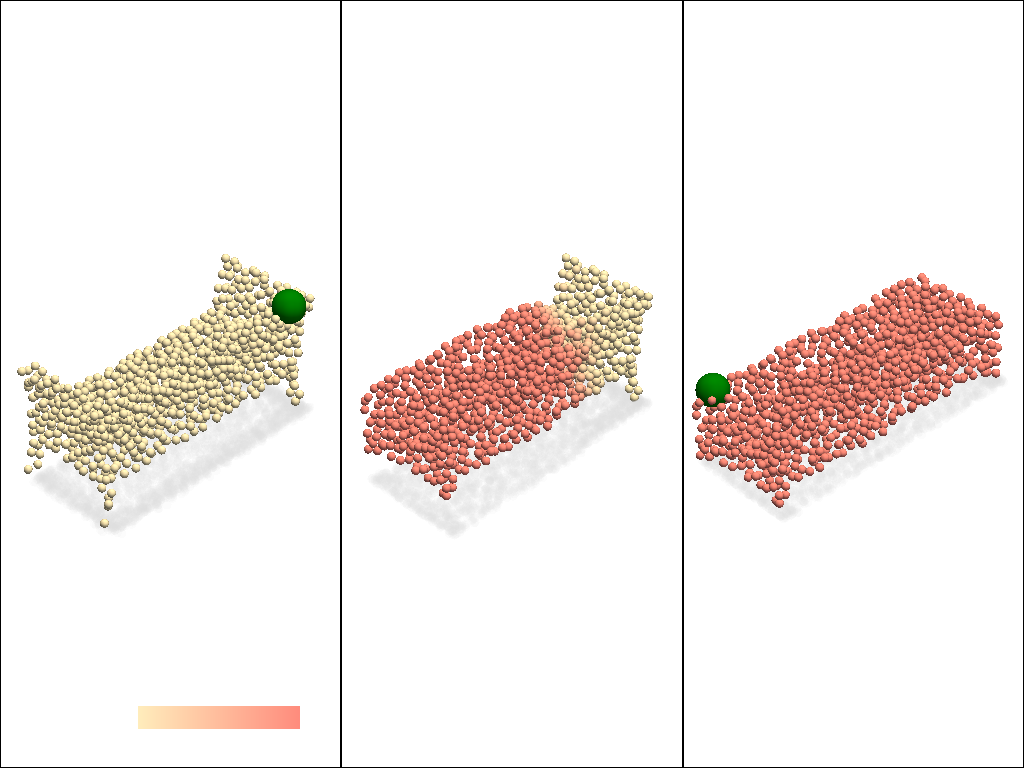

14


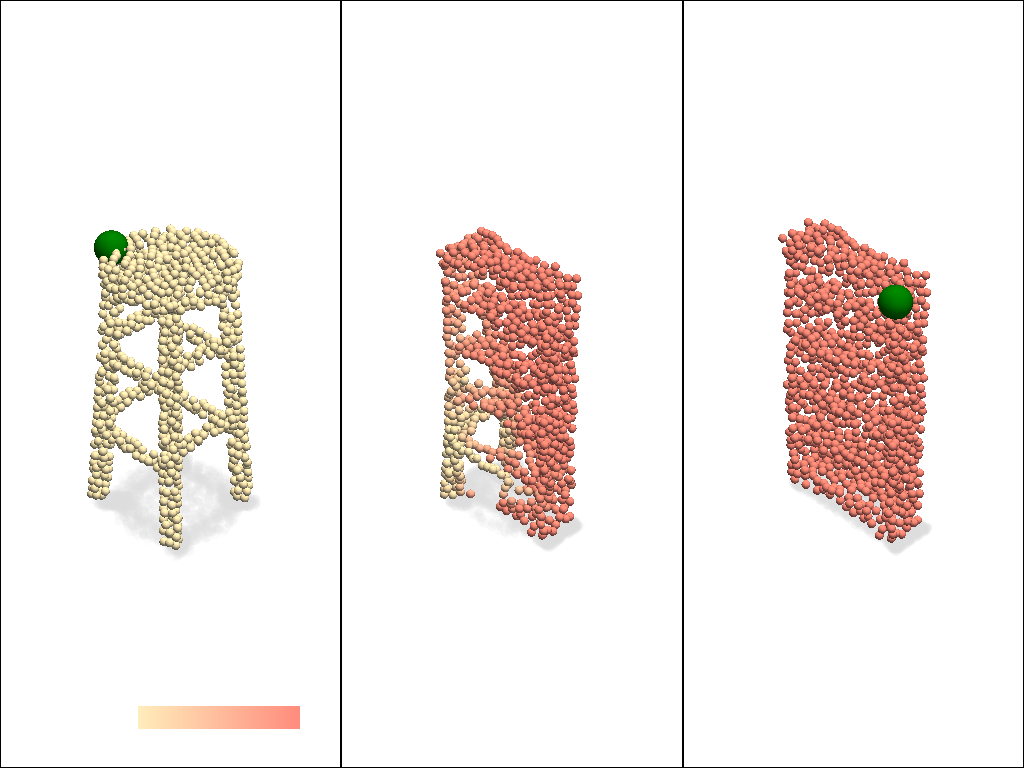

15


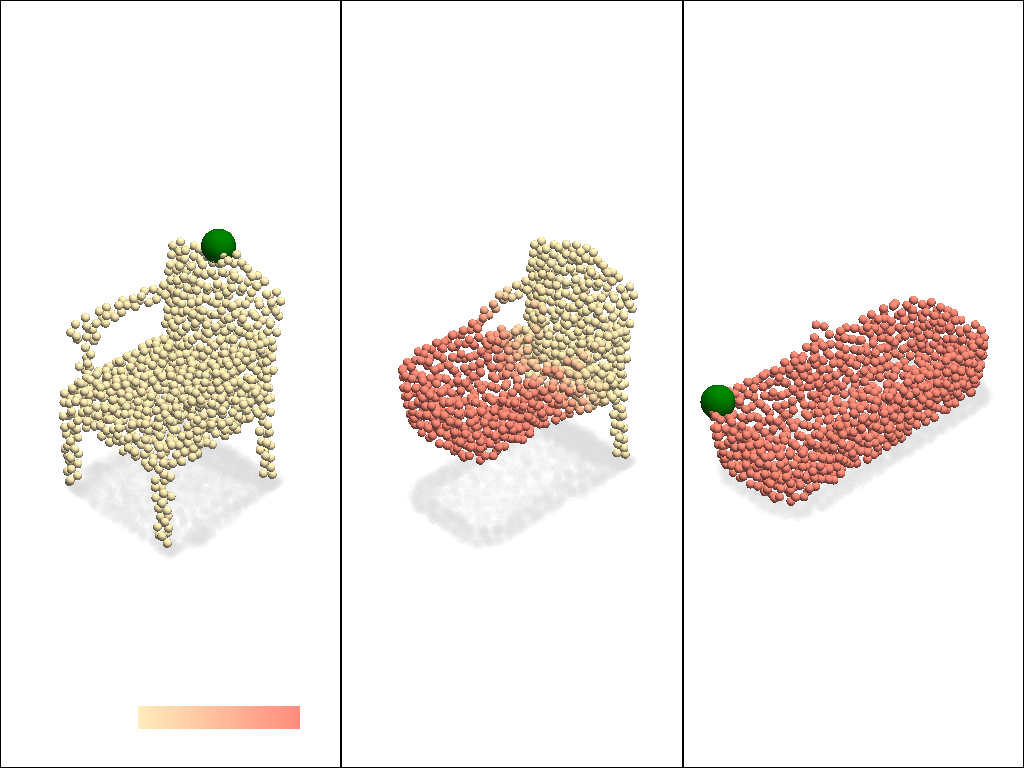

2


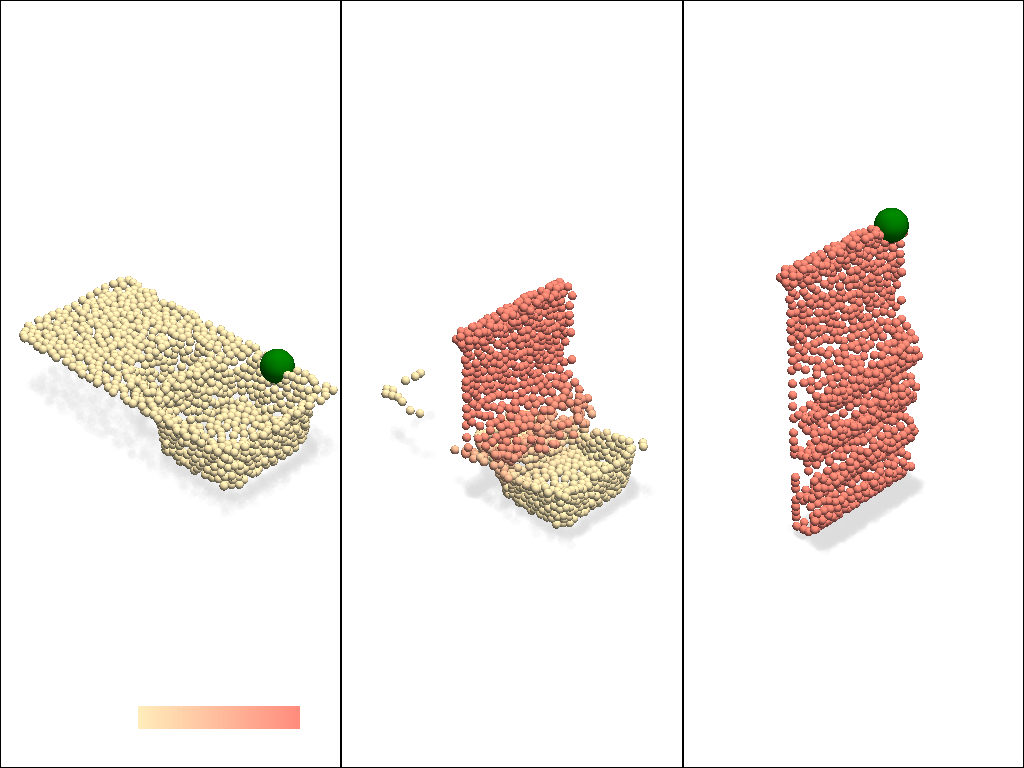

3


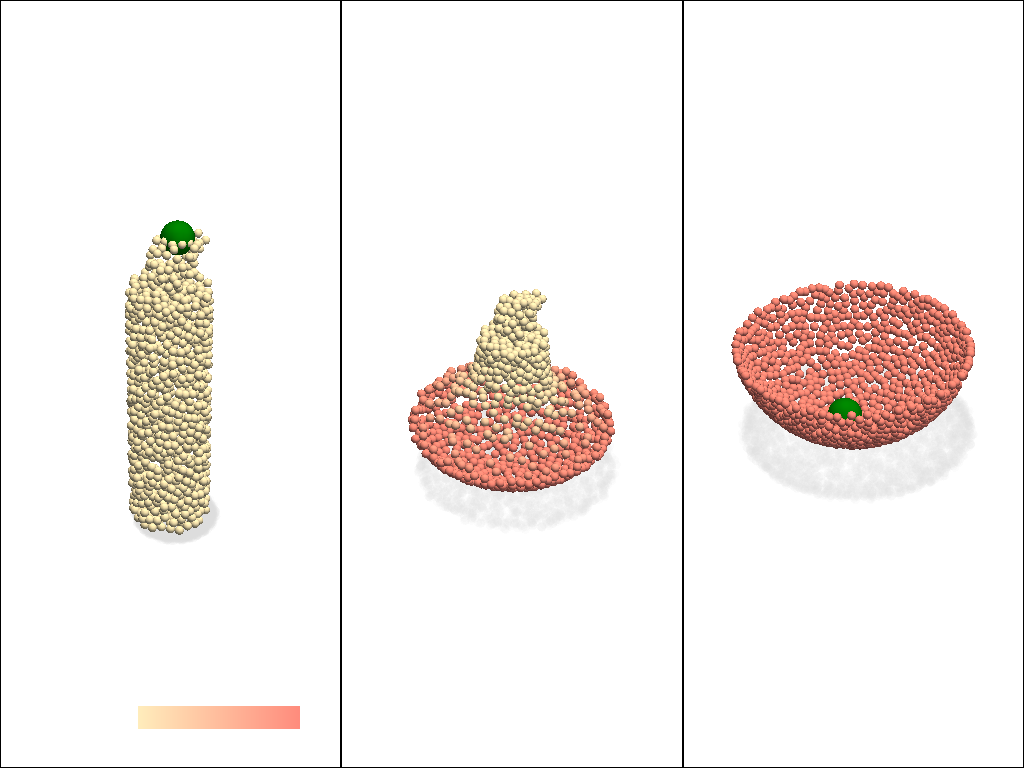

In [85]:
# idxs = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3]
idxs = [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 3]
# for i in range(batch_size):
for i in idxs:
    print(i)
    # print(dic['alpha'][i])
    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.zeros(len(A[i]))
    # point_cloud['y'] = normalize(A_saliency[i])
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, A.cpu().numpy()[i][:,[0,2,1]], point_size)
    
    anchor = pv.PolyData(dic['anchor_ori'][i].cpu().numpy()[[0,2,1]])
    plotter.add_points(anchor, point_size=35, render_points_as_spheres=True, color="g")

# 
    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = saliency_new[i] #normalize(saliency_new[i])
    point_cloud['y'] = aug_weight[i]
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos

    get_shadow(plotter, aug.cpu().numpy()[i][:,[0,2,1]], point_size)

    

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B.cpu().numpy()[i][:,[0,2,1]])
    point_cloud['y'] = np.ones(len(A[i]))
    # point_cloud['y'] = normalize(B_saliency[i])
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_pos
    get_shadow(plotter, B.cpu().numpy()[i][:,[0,2,1]], point_size)
    anchor = pv.PolyData(dic['anchor_perm'][i].cpu().numpy()[[0,2,1]])
    plotter.add_points(anchor, point_size=35, render_points_as_spheres=True, color="g")
    
    light = pv.Light(intensity=0.20, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
#         light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light = pv.Light(intensity=0.16, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.show(jupyter_backend="static")
    plotter.screenshot(path + f"test_color_{i}.png")



## Aug Codesaug_weight

In [11]:
def ours(xyz, perm, alpha=None, anchor=None, x=None, saliency=None, num_points=1024, sigma=0.1, beta=None, saliency_ver=0):
    """
    Args:
        xyz (B,N,3): 
        label (B): 
        x (B,D,N): Defaults to None.
        saliency (B,N): Defaults to None.
    """        


    _, ass = EMD(xyz, perm, 0.005, 10000) # mapping
    ass = ass.long()
    perm_new = torch.zeros_like(perm).to(perm.device)

    for i in range(batch_size):
        perm_new[i] = perm[i][ass[i]]

    if anchor is not None:
        anchor_ori, anchor_perm = xyz[torch.arange(len(xyz)),anchor[0],:], perm[torch.arange(len(perm)),anchor[1], :]
    #random_sampling
    elif saliency is None:
        anc_idx = torch.randperm(num_points)[:2]
        anchor_ori, anchor_perm = xyz[:,anc_idx[0],:], perm_new[:,anc_idx[1], :]
    #weighted sampling
    elif saliency_ver == 1:
        anc_idx = torch.multinomial(saliency, 2, replacement=True)
        anchor_ori = xyz[torch.arange(batch_size),anc_idx[:,0]]
        anchor_perm = xyz[torch.arange(batch_size),anc_idx[:,1]][idxs]
    #max
    elif saliency_ver == 2:
        anc_idx = saliency.max(1)[1]
        anchor_ori = xyz[torch.arange(batch_size),anc_idx]
        anchor_perm = anchor_ori[idxs]

    if beta is not None:
        alpha = beta.sample((batch_size,)).to([perm.device])
    elif alpha is not None:
        alpha = alpha
    else:
        alpha = 0.5

    sub_ori = xyz - anchor_ori[:,None,:]
    sub_ori = ((sub_ori) ** 2).sum(2).sqrt()
    weight_ori = torch.exp(-0.5 * (sub_ori ** 2) / (sigma ** 2))  #(M,N)
    weight_ori = weight_ori * alpha

    sub_perm = perm_new - anchor_perm[:,None,:]
    sub_perm = ((sub_perm) ** 2).sum(2).sqrt()   
    weight_perm = torch.exp(-0.5 * (sub_perm ** 2) / (sigma ** 2))  #(M,N)
    weight_perm = weight_perm * (1-alpha)

    weight = (torch.cat([weight_ori[...,None],weight_perm[...,None]],-1)) + 1e-16
    weight = weight/weight.sum(-1)[...,None]

    #mixup sampe
    if x is None:
        x = xyz
        perm_x_new = perm_new
    else:
        x = x.permute(0,2,1)
        perm_x = x[idxs]
        perm_x_new = torch.zeros_like(perm_x).cuda()
        for i in range(batch_size):
            perm_x_new[i] = perm_x[i][ass[i]]

    x = weight[:,:,0:1] * x + weight[:,:,1:] * perm_x_new
#     x = x.permute(0,2,1)


    return x, {"mix" : x, "perm" : perm_new, "weight":weight}

## Prepare viz

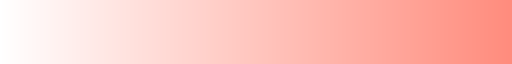

In [12]:
import pyvista as pv
import numpy as np

def get_shadow(plotter, pos, point_size, scale=3, origin=None, opacitiy=0.1, color= "#dddddd"):
    #pos (n,3)
    pos  =pos.repeat(scale, 0) 
    pos +=  np.random.rand(pos.shape[0],pos.shape[1])/20

    point_cloud = pv.PolyData(pos)

    if origin is None:
        origin = [0,0,pos[:,2].min() - 0.05]
    point_cloud = point_cloud.project_points_to_plane(origin=origin, normal=[0,0,-1])

    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True,\
                        opacity=opacitiy, color = color, lighting=False) 


pv.start_xvfb()
from matplotlib.colors import ListedColormap
# s_color = np.array([255, 237, 188, 255])/255
s_color = np.array([255, 255, 255, 255])/255
e_color = np.array([255, 140, 125, 255])/255
lin = np.linspace(0,1,256)
np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)

color_map = np.expand_dims(s_color,1) + np.expand_dims((e_color - s_color),1)*np.expand_dims(lin,0)
cmap = ListedColormap(color_map.transpose((1,0)))
cmap

In [13]:
def visualize_batch(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, index=None):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()
    
    if index==None:
        index = range(len(aug))

    for i in index:
        plotter = pv.Plotter(notebook=True, shape=(1,3))
            
        plotter.subplot(0, 0)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(A[i][:,[0,2,1]])
        # point_cloud['y'] = np.zeros(len(A[i]))
        point_cloud['y'] = A_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, A[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 1)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(aug[i][:,[0,2,1]])
        point_cloud['y'] = aug_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, aug[i][:,[0,2,1]], point_size)
        
        plotter.subplot(0, 2)
        plotter.background_color = "W"
        point_cloud = pv.PolyData(B[i][:,[0,2,1]])
        # point_cloud['y'] = np.ones(len(B[i]))
        point_cloud['y'] = B_weight[i]
        plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
        plotter.camera_position = camera_position
        get_shadow(plotter, B[i][:,[0,2,1]], point_size)

#         light = pv.Light(intensity=0.15, shadow_attenuation = 0)
        light = pv.Light(intensity=0.20, shadow_attenuation = 0)
        light.set_direction_angle(30,0)
        plotter.add_light(light)
#         light = pv.Light(intensity=0.12, shadow_attenuation = 0)
        light = pv.Light(intensity=0.16, shadow_attenuation = 0)
        light.set_direction_angle(30,180)
        plotter.add_light(light)

        plotter.show()
    return plotter
    
def save_pdf(A, B, aug, cmap, point_size, camera_position, A_weight, B_weight, aug_weight, filename):
    if isinstance(A, torch.Tensor):
        A = A.cpu().numpy()
        B = B.cpu().numpy()
        aug = aug.cpu().numpy()

    plotter = pv.Plotter(notebook=True, shape=(1,3))

    plotter.subplot(0, 0)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(A[:,[0,2,1]])
    # point_cloud['y'] = np.zeros(len(A[i]))
    point_cloud['y'] = A_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, A[:,[0,2,1]], point_size)

    plotter.subplot(0, 1)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(aug[:,[0,2,1]])
    point_cloud['y'] = aug_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, aug[:,[0,2,1]], point_size)

    plotter.subplot(0, 2)
    plotter.background_color = "W"
    point_cloud = pv.PolyData(B[:,[0,2,1]])
    # point_cloud['y'] = np.ones(len(B[i]))
    point_cloud['y'] = B_weight
    plotter.add_points(point_cloud, point_size=point_size, render_points_as_spheres=True, cmap=cmap)
    plotter.camera_position = camera_position
    get_shadow(plotter, B[:,[0,2,1]], point_size)

    light = pv.Light(intensity=0.15, shadow_attenuation = 0)
    light.set_direction_angle(30,0)
    plotter.add_light(light)
    light = pv.Light(intensity=0.12, shadow_attenuation = 0)
    light.set_direction_angle(30,180)
    plotter.add_light(light)

    plotter.save_graphic(filename)


In [14]:
camera_pos = [1,-1,1]#,[0,0,1]]
point_size = 7

## VIZ

In [15]:
batch_size = 16
num_points = 1024
point_size = 9
camera_pos = camera_pos
class_1 = 17
class_2 = 8

# A, B, idx_list = get_pc_batch(class_1, class_2, batch_size, num_points=num_points)

idx_list = [[282]*batch_size, [1807]*batch_size]
A, B, idx_list = get_pc_batch(class_1, class_2, batch_size, idx_list=idx_list, num_points=num_points)

### Ours

In [16]:
guitar_idx = 282
chair_idx = 1807

In [17]:
anchor =[]
anchor.append(torch.argmax(A[:,:,0], 1))
anchor.append(torch.argmin(B[:,:,0], 1))
output = ours(A, B, alpha=0.9834, anchor=anchor, sigma=0.3) # sigma=0.4)

aug = output[0]
# B = output[1]['perm']
A_weight = np.zeros(A.shape[:2])
A_weight[np.arange(len(A)), anchor[0]] = 1
B_weight = np.ones(B.shape[:2])
B_weight[np.arange(len(B)), anchor[1]] = 0
aug_weight = output[1]['weight'][:,:,1]
print(torch.mean(aug_weight, 1))
labels = torch.mean((output[1]['weight'][:,:,1])/torch.sum(output[1]['weight'],2),1)
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos, 
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
#                )
                index=[0])
# visualize_batch(output[1]['perm'], B, aug, cmap, point_size=point_size, camera_position=camera_pos,
#  A_weight=B_weight, B_weight=B_weight, aug_weight=aug_weight, labels=labels)



tensor([0.4501, 0.4503, 0.4499, 0.4500, 0.4498, 0.4502, 0.4506, 0.4499, 0.4499,
        0.4505, 0.4505, 0.4503, 0.4503, 0.4509, 0.4507, 0.4504])


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [18]:
anchor =[]
anchor.append(torch.argmax(A[:,:,0], 1))
anchor.append(torch.argmin(B[:,:,0], 1))
output = ours(A, B, alpha=0.8, anchor=anchor, sigma=0.4)

aug = output[0]
# B = output[1]['perm']
A_weight = np.zeros(A.shape[:2])
A_weight[np.arange(len(A)), anchor[0]] = 1
B_weight = np.ones(B.shape[:2])
B_weight[np.arange(len(B)), anchor[1]] = 0
aug_weight = output[1]['weight'][:,:,1]

labels = torch.mean((output[1]['weight'][:,:,1])/torch.sum(output[1]['weight'],2),1)
visualize_batch(A, B, aug, cmap, point_size=point_size, camera_position=camera_pos, 
                A_weight=A_weight, B_weight=B_weight, aug_weight=aug_weight, 
#                )
                index=[0])
# visualize_batch(output[1]['perm'], B, aug, cmap, point_size=point_size, camera_position=camera_pos,
#  A_weight=B_weight, B_weight=B_weight, aug_weight=aug_weight, labels=labels)


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
filename = './injae/ours_0.45.pdf'
idx = -1
save_pdf(A[idx], B[idx], aug[idx], cmap, point_size=point_size, camera_position=camera_pos,
                A_weight=A_weight[idx], B_weight=B_weight[idx], aug_weight=aug_weight[idx], 
                filename=filename)